# Face Detection Demo - Sliding Window

Apply trained AdaBoost classifier to full images using sliding window approach.

**Part 2 Implementation**:
- Single-scale detection on test images
- Multi-scale detection with image pyramid
- Non-maximum suppression (NMS)
- Bounding box visualization

**AI Usage**: Notebook structure assisted by Claude Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, color
import pickle
import sys
from pathlib import Path
from tqdm import tqdm

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from classifiers.adaboost import AdaBoostClassifier
from features.haar_features import generate_haar_features
from detector.sliding_window import (
    sliding_window, multi_scale_detection, 
    non_maximum_suppression, Detection
)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Trained Model

In [2]:
# Load AdaBoost model
model_path = Path('../data/models/adaboost_v1_T50.pkl')
print(f'Loading model from {model_path}...')

classifier = AdaBoostClassifier.load(model_path)
print(f'Loaded: {classifier}')
print(f'  Weak classifiers: {len(classifier.weak_classifiers)}')
print(f'  Total alpha: {sum(classifier.alphas):.2f}')

Loading model from ..\data\models\adaboost_v1_T50.pkl...
Loaded: AdaBoostClassifier(n_weak=50, threshold=0.500)
  Weak classifiers: 50
  Total alpha: 17.25


## 2. Generate Features (Same as Training)

In [3]:
# Must use same features as training!
print('Generating Haar features...')
features = generate_haar_features(window_size=16, max_features=10000)
print(f'Generated {len(features)} features')

Generating Haar features...
Generating Haar features for 16×16 window...
  Generating 2-rectangle horizontal features...
  Generating 2-rectangle vertical features...
Generated 10000 features


## 3. Load Test Image

Use an image from Faces94 dataset

Loading test image: ..\Faces94\male\9326871\9326871.1.jpg
Image shape: (200, 180)


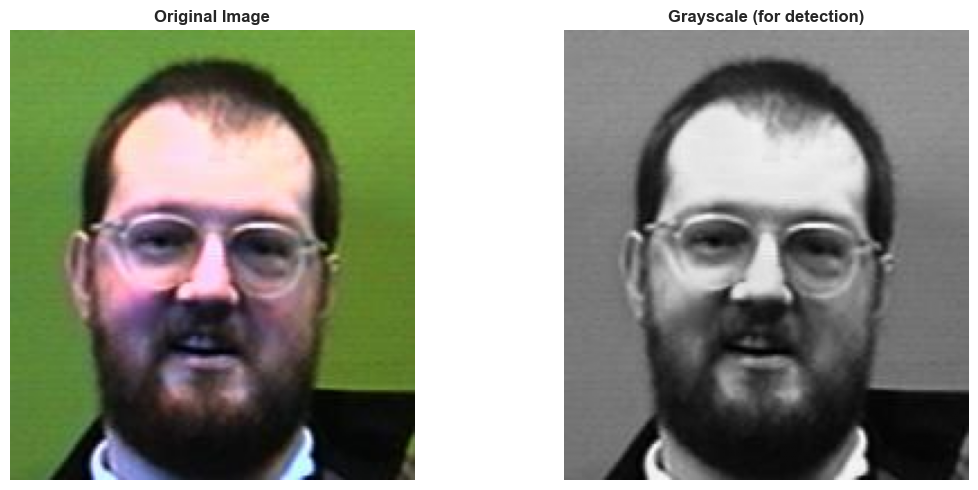

In [4]:
# Load a sample image from male/ folder
test_image_path = Path('../Faces94/male/suatt/suatt.1.jpg')

if not test_image_path.exists():
    # Try alternative path
    test_image_path = Path('../Faces94/male').glob('*/*.1.jpg').__next__()

print(f'Loading test image: {test_image_path}')
image = io.imread(test_image_path)

# Convert to grayscale if needed
if len(image.shape) == 3:
    image_gray = color.rgb2gray(image)
    image_gray = (image_gray * 255).astype(np.uint8)
else:
    image_gray = image

print(f'Image shape: {image_gray.shape}')

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(image if len(image.shape) == 3 else image_gray, cmap='gray')
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(image_gray, cmap='gray')
axes[1].set_title('Grayscale (for detection)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4. Single-Scale Detection

Apply 16x16 sliding window at original image scale

In [5]:
# Parameters
window_size = 16
step_size = 2      # Stride
threshold = 0.6    # Confidence threshold (higher = fewer detections)

print(f'Running single-scale detection...')
print(f'  Window: {window_size}x{window_size}')
print(f'  Step: {step_size}')
print(f'  Threshold: {threshold}')

detections = sliding_window(
    classifier, 
    image_gray, 
    features,
    window_size=window_size,
    step_size=step_size,
    threshold=threshold
)

print(f'\nFound {len(detections)} detections')

Running single-scale detection...
  Window: 16x16
  Step: 2
  Threshold: 0.6
Scanning image 180x200 with 16x16 window, step=2
Found 111 detections

Found 111 detections
Found 111 detections

Found 111 detections


## 5. Visualize Detections

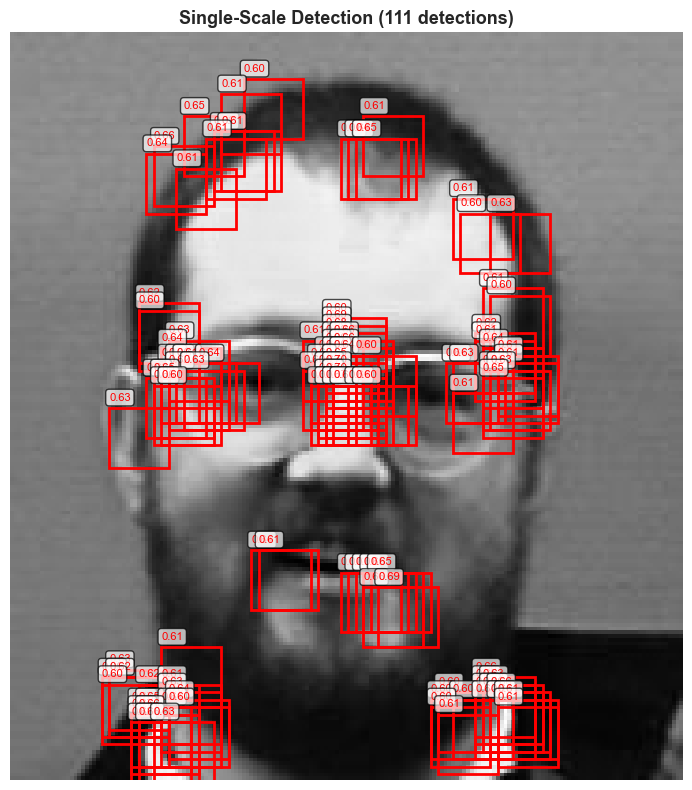

In [6]:
def visualize_detections(image, detections, title='Detections'):
    """Draw bounding boxes on image"""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image, cmap='gray')
    
    for det in detections:
        rect = patches.Rectangle(
            (det.x, det.y), det.width, det.height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add confidence score
        ax.text(
            det.x, det.y - 2, 
            f'{det.confidence:.2f}',
            color='red', fontsize=8, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
        )
    
    ax.set_title(f'{title} ({len(detections)} detections)', fontsize=13, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    return fig

# Visualize
fig = visualize_detections(image_gray, detections, 'Single-Scale Detection')
plt.savefig('../results/figures/detection_single_scale.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Multi-Scale Detection

Create image pyramid and detect at multiple scales

In [7]:
# Multi-scale parameters
scale_factor = 1.2  # Pyramid scaling
threshold_ms = 0.5  # Lower threshold for multi-scale

print('Running multi-scale detection...')
print(f'  Scale factor: {scale_factor}')
print(f'  Threshold: {threshold_ms}')

detections_ms = multi_scale_detection(
    classifier,
    image_gray,
    features,
    window_size=window_size,
    step_size=step_size,
    scale_factor=scale_factor,
    threshold=threshold_ms
)

print(f'\nTotal detections before NMS: {len(detections_ms)}')

Running multi-scale detection...
  Scale factor: 1.2
  Threshold: 0.5
Created pyramid with 14 scales

Scale 1.00: (200, 180)
Scanning image 180x200 with 16x16 window, step=2
Found 1154 detections

Scale 1.20: (200, 180)
Scanning image 180x200 with 16x16 window, step=2
Found 1154 detections

Scale 1.20: (200, 180)
Scanning image 180x200 with 16x16 window, step=2
Found 1154 detections

Scale 1.44: (200, 180)
Scanning image 180x200 with 16x16 window, step=2
Found 1154 detections

Scale 1.44: (200, 180)
Scanning image 180x200 with 16x16 window, step=2
Found 1154 detections

Scale 1.73: (200, 180)
Scanning image 180x200 with 16x16 window, step=2
Found 1154 detections

Scale 1.73: (200, 180)
Scanning image 180x200 with 16x16 window, step=2
Found 1154 detections

Scale 2.07: (100, 90)
Scanning image 90x100 with 16x16 window, step=2
Found 1154 detections

Scale 2.07: (100, 90)
Scanning image 90x100 with 16x16 window, step=2
Found 316 detections

Scale 2.49: (100, 90)
Scanning image 90x100 with

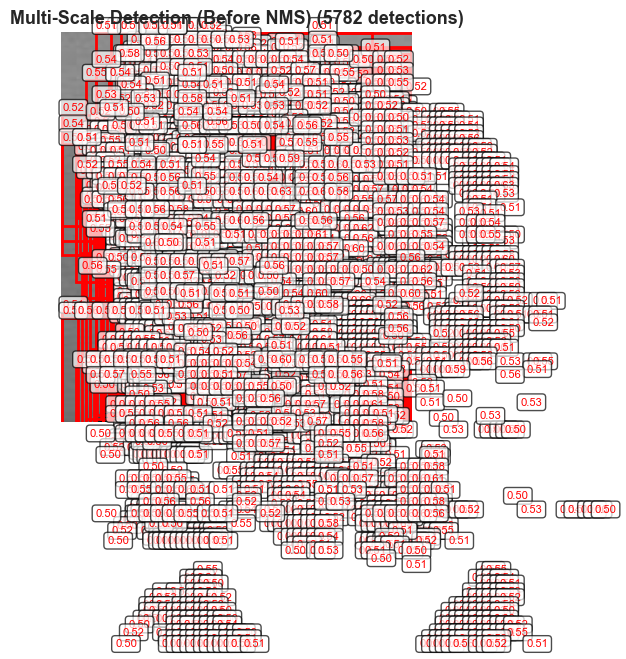

In [8]:
# Visualize before NMS
fig = visualize_detections(image_gray, detections_ms, 'Multi-Scale Detection (Before NMS)')
plt.savefig('../results/figures/detection_multi_scale_before_nms.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Non-Maximum Suppression

Remove overlapping detections

In [9]:
# Apply NMS
overlap_threshold = 0.3  # IoU threshold

print(f'Applying NMS with IoU threshold: {overlap_threshold}')
detections_nms = non_maximum_suppression(detections_ms, overlap_threshold)

print(f'Detections after NMS: {len(detections_nms)}')

Applying NMS with IoU threshold: 0.3
NMS: 335 detections after suppression
Detections after NMS: 335
NMS: 335 detections after suppression
Detections after NMS: 335


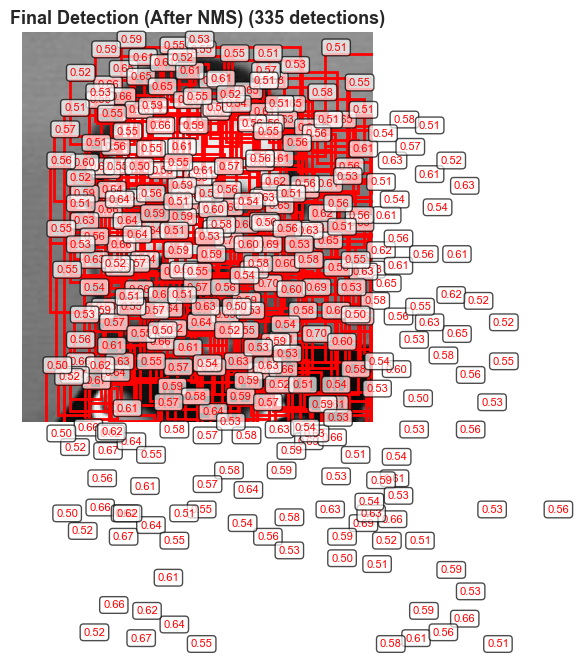

In [10]:
# Visualize final result
fig = visualize_detections(image_gray, detections_nms, 'Final Detection (After NMS)')
plt.savefig('../results/figures/detection_final.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Side-by-Side Comparison

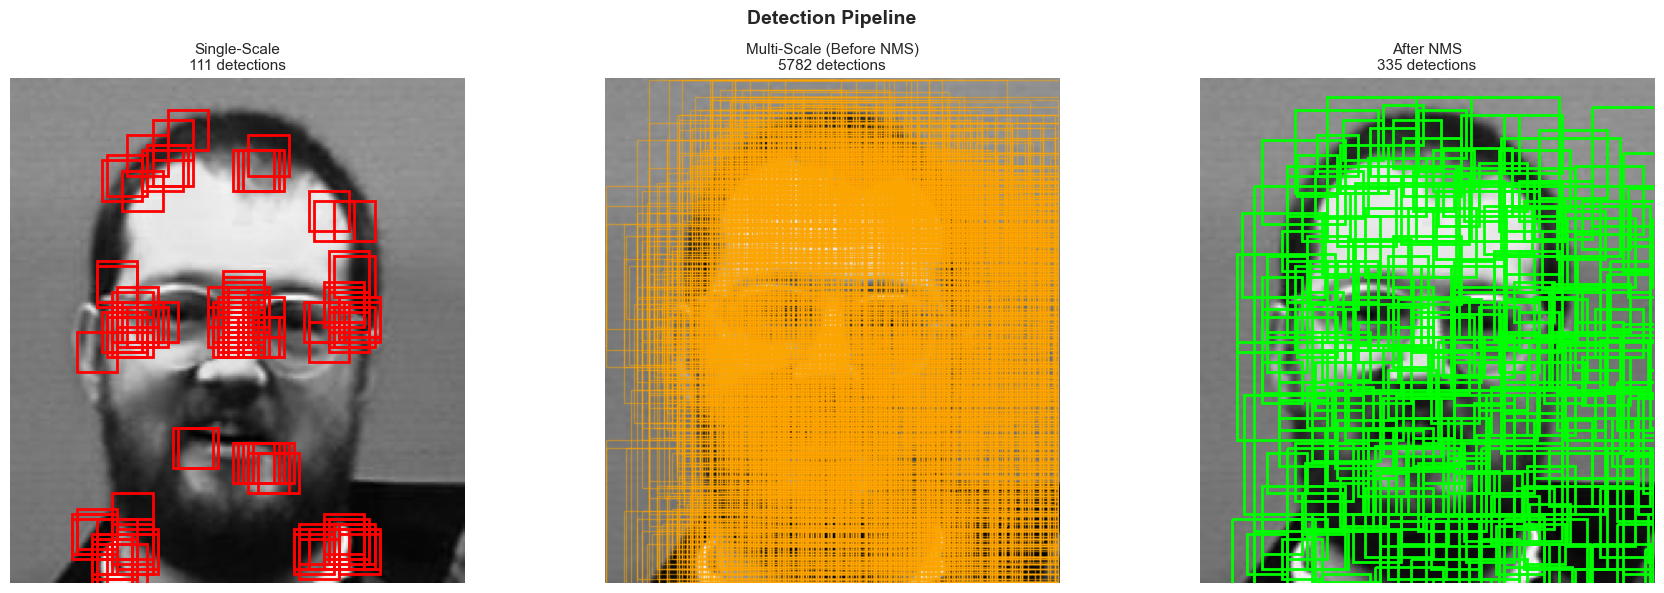

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Detection Pipeline', fontsize=14, fontweight='bold')

# Single scale
axes[0].imshow(image_gray, cmap='gray')
for det in detections:
    rect = patches.Rectangle(
        (det.x, det.y), det.width, det.height,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    axes[0].add_patch(rect)
axes[0].set_title(f'Single-Scale\n{len(detections)} detections', fontsize=11)
axes[0].axis('off')

# Multi-scale before NMS
axes[1].imshow(image_gray, cmap='gray')
for det in detections_ms:
    rect = patches.Rectangle(
        (det.x, det.y), det.width, det.height,
        linewidth=1, edgecolor='orange', facecolor='none', alpha=0.5
    )
    axes[1].add_patch(rect)
axes[1].set_title(f'Multi-Scale (Before NMS)\n{len(detections_ms)} detections', fontsize=11)
axes[1].axis('off')

# After NMS
axes[2].imshow(image_gray, cmap='gray')
for det in detections_nms:
    rect = patches.Rectangle(
        (det.x, det.y), det.width, det.height,
        linewidth=2, edgecolor='lime', facecolor='none'
    )
    axes[2].add_patch(rect)
axes[2].set_title(f'After NMS\n{len(detections_nms)} detections', fontsize=11)
axes[2].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/detection_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Test on Multiple Images

Scanning image 180x200 with 16x16 window, step=2
Found 111 detections
Scanning image 180x200 with 16x16 window, step=2
Found 111 detections
Scanning image 180x200 with 16x16 window, step=2
Found 116 detections
Scanning image 180x200 with 16x16 window, step=2
Found 116 detections
Scanning image 180x200 with 16x16 window, step=2
Found 95 detections
Scanning image 180x200 with 16x16 window, step=2
Found 95 detections
Scanning image 180x200 with 16x16 window, step=2
Found 83 detections
Scanning image 180x200 with 16x16 window, step=2
Found 83 detections
Scanning image 180x200 with 16x16 window, step=2
Found 81 detections
Scanning image 180x200 with 16x16 window, step=2
Found 81 detections
Scanning image 180x200 with 16x16 window, step=2
Found 111 detections
Found 111 detections


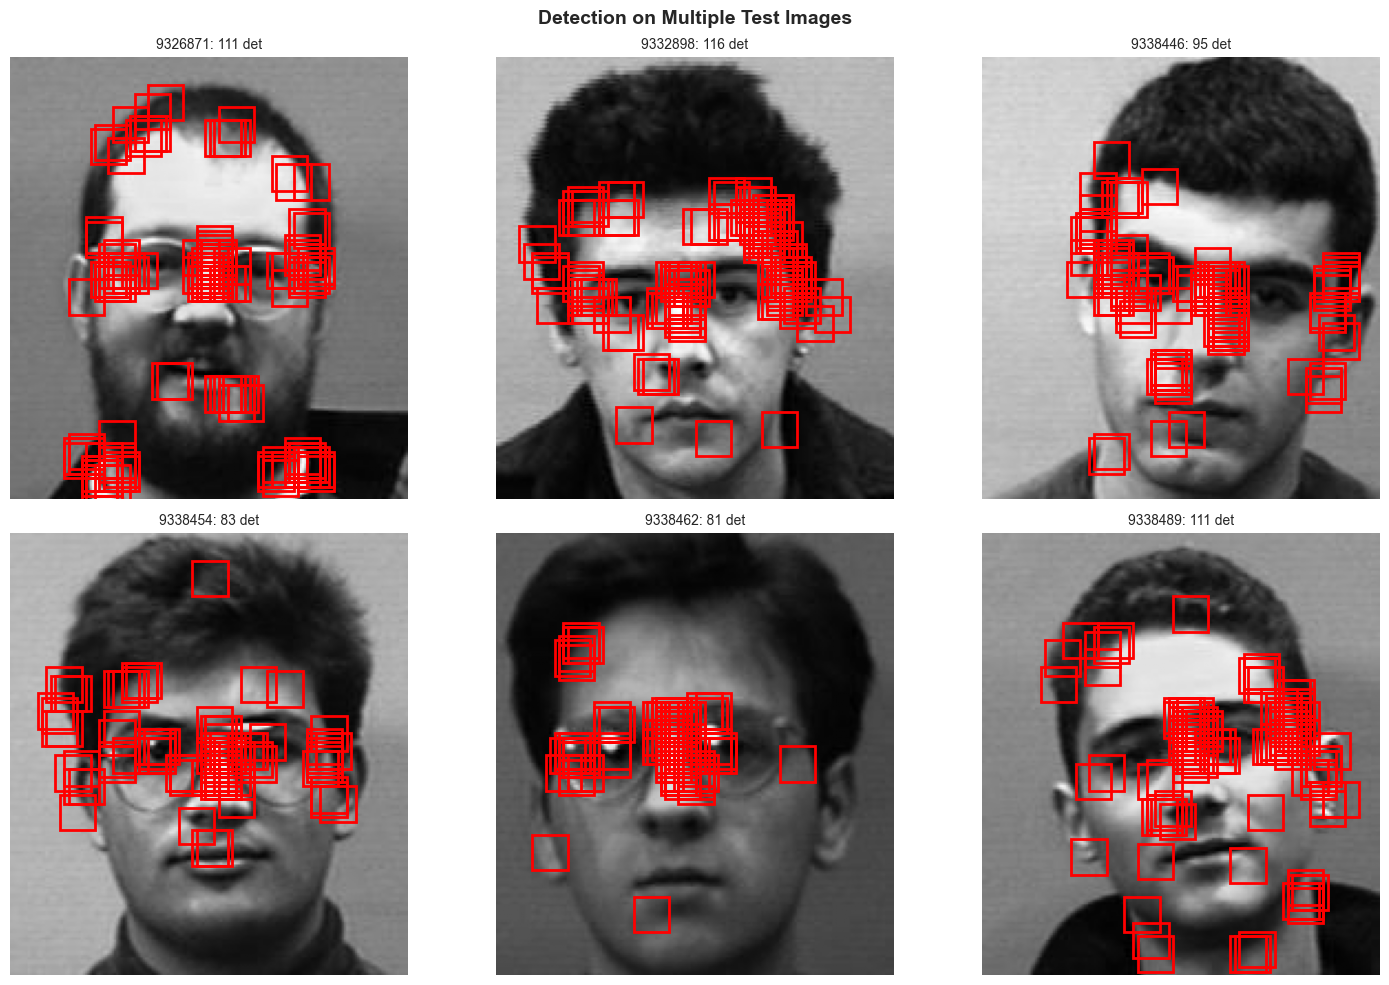

In [12]:
# Load multiple test images
test_folder = Path('../Faces94/male')
test_images = list(test_folder.glob('*/*.1.jpg'))[:6]  # First 6 images

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Detection on Multiple Test Images', fontsize=14, fontweight='bold')

for ax, img_path in zip(axes.flat, test_images):
    # Load and convert
    img = io.imread(img_path)
    if len(img.shape) == 3:
        img_gray = (color.rgb2gray(img) * 255).astype(np.uint8)
    else:
        img_gray = img
    
    # Detect
    dets = sliding_window(classifier, img_gray, features, 
                         window_size=16, step_size=2, threshold=0.6)
    
    # Visualize
    ax.imshow(img_gray, cmap='gray')
    for det in dets:
        rect = patches.Rectangle(
            (det.x, det.y), det.width, det.height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
    
    ax.set_title(f'{img_path.parent.name}: {len(dets)} det', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/detection_multiple.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Detection Statistics

In [13]:
print('=' * 60)
print('DETECTION DEMO SUMMARY')
print('=' * 60)
print(f'\nModel: AdaBoost T=50')
print(f'  Test accuracy: 84.97%')
print(f'  Features: 10,000 Haar features')

print(f'\nDetection Parameters:')
print(f'  Window size: {window_size}x{window_size}')
print(f'  Step size: {step_size} pixels')
print(f'  Scale factor: {scale_factor}')
print(f'  Confidence threshold: {threshold_ms}')

print(f'\nResults on Sample Image:')
print(f'  Single-scale detections: {len(detections)}')
print(f'  Multi-scale before NMS: {len(detections_ms)}')
print(f'  Final (after NMS): {len(detections_nms)}')

print('\n' + '=' * 60)
print('[OK] Part 2 Detection Demo Complete!')
print('=' * 60)

DETECTION DEMO SUMMARY

Model: AdaBoost T=50
  Test accuracy: 84.97%
  Features: 10,000 Haar features

Detection Parameters:
  Window size: 16x16
  Step size: 2 pixels
  Scale factor: 1.2
  Confidence threshold: 0.5

Results on Sample Image:
  Single-scale detections: 111
  Multi-scale before NMS: 5782
  Final (after NMS): 335

[OK] Part 2 Detection Demo Complete!


## Observations

**Expected Results:**
- Faces94 images are centered, single-face portraits
- Should detect 1-2 faces per image (true face + possible false positives)
- 16x16 window is small - works best on Faces94 resolution

**Challenges:**
- Small window size limits detection to similar-sized faces
- False positives from textured backgrounds
- Multi-scale needed for faces at different distances

**Improvements for V2:**
- Larger training window (24x24)
- More features (50k)
- Better cascade to reduce false positives
- Test on multi-face group photos